In [1]:
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt

# 커스텀 모듈 import
from infer_target import InferTarget
from encodingModules.lstm import LSTMAE
from encodingModules.graph import GAE
from encodingModules.transformer import TAE

/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
2026-01-15 21:28:17.118162: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-15 21:28:17.163597: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-15 21:28:17.163630: E external/local_xla/xla/stream_execut

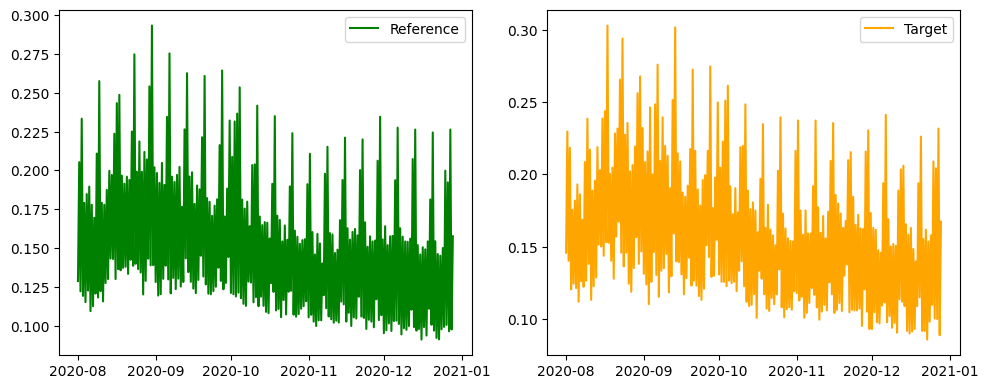

In [2]:
from dataproc import DataProc
import pandas as pd
import matplotlib.pyplot as plt

dp = DataProc('hotwater')
train, test, total = dp.load_data('water')

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train.iloc[:300].mean(axis=1), label='Reference', color='green')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test.iloc[:300].mean(axis=1), label='Target', color='orange')
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
hw_cluster = InferTarget('hotwater', 'cluster')
hw_test = InferTarget('hotwater', 'test')

In [3]:
# 결과 데이터프레임 생성
cluster_methods = ['kmedoids', 'kmeans', 'agglomerative', 'gmm']
df_cluster = pd.DataFrame(columns=cluster_methods)
df_test = pd.DataFrame(columns=cluster_methods)

In [4]:
# AVG
avg_cluster_mean = hw_cluster.regionA_average()
avg_test_mean = hw_test.regionA_average()

print('\n[AVG]')
print(f'Cluster MAE mean: {avg_cluster_mean}')
print(f'Test MAE mean: {avg_test_mean}')

Total : 0.06304533908764447
Total : 0.05919483921685588

[AVG]
Cluster MAE mean: 0.06304533908764447
Test MAE mean: 0.05919483921685588


/root/workspace/AMI/InferProj/infer_target.py:59: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  np.tile(self.target_total[self.region_A][self.start_idx:self.end_idx].mean(axis=1)[:, np.newaxis], (1, len(self.region_B))))
/root/workspace/AMI/InferProj/infer_target.py:59: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  np.tile(self.target_total[self.region_A][self.start_idx:self.end_idx].mean(axis=1)[:, np.newaxis], (1, len(self.region_B))))


In [5]:
# RAE
total_cluster = []
total_test = []
for cluster_method in cluster_methods:
    mae_cluster = []
    mae_test = []
    for i in range(101, 105):
        cluster, si = hw_cluster.cluster_by_RAE(cluster_method,i)
        mae = hw_cluster.predict_target(cluster, si)
        mae_cluster.append(mae)
        cluster, si = hw_test.cluster_by_RAE(cluster_method,i)
        mae = hw_test.predict_target(cluster, si)
        mae_test.append(mae)
    
    print(f'[{cluster_method}]')
    print('cluster MAE mean:',(c_mean:=np.array(mae_cluster).mean()).round(10))
    print('cluster MAE std:',(c_std:=np.array(mae_cluster).std()).round(10))
    print('test MAE mean:',(t_mean:=np.array(mae_test).mean()).round(10))
    print('test MAE std:',(t_std:=np.array(mae_test).std()).round(10))
    print()
    
    total_cluster.append(c_mean)
    total_test.append(t_mean)

df_cluster.loc['RAE'] = total_cluster
df_test.loc['RAE'] = total_test

[kmedoids]
cluster MAE mean: 0.0620453939
cluster MAE std: 0.0005412463
test MAE mean: 0.0586267882
test MAE std: 0.0004299232

[kmeans]
cluster MAE mean: 0.0616302188
cluster MAE std: 0.0001298744
test MAE mean: 0.057955086
test MAE std: 0.0001052751

[agglomerative]
cluster MAE mean: 0.062094242
cluster MAE std: 0.0001083833
test MAE mean: 0.0581246697
test MAE std: 0.0001720758

[gmm]
cluster MAE mean: 0.0622725281
cluster MAE std: 0.0002177212
test MAE mean: 0.0580743548
test MAE std: 0.0002106784



In [8]:
from sklearn.decomposition import PCA

arr_hidden = pd.read_csv(f'/root/workspace/AMI/InferProj/hidden/gae_hotwater/h_r_0_0.csv',index_col=0)

pca = PCA(n_components=2)
arr_hidden_pca = pca.fit_transform(arr_hidden)
print(arr_hidden_pca.shape)

(1080, 2)


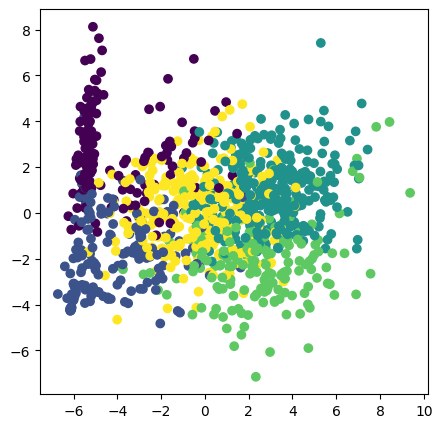

In [9]:
df_households = pd.DataFrame(arr_hidden_pca, columns=['x','y'])
df_households['cluster'] = cluster.labels_
plt.figure(figsize=(5,5))
plt.scatter(df_households['x'], df_households['y'], c=df_households['cluster'])
plt.show()

In [3]:
cluster_method = 'kmeans'
mae_cluster = []
mae_test = []
for i in range(3):
    cluster, refer_si = hw_cluster.cluster_by_GAE(cluster_method,i, dim=56)
    refer_true, refer_infer, mae = hw_cluster.predict_target(cluster, refer_si)
    mae_cluster.append(mae)
    cluster, target_si = hw_test.cluster_by_GAE(cluster_method,i, dim=56)
    target_true, target_infer, mae = hw_test.predict_target(cluster, target_si)
    mae_test.append(mae)

print(f'[{cluster_method}]')
print('cluster MAE mean:',(c_mean:=np.array(mae_cluster).mean()).round(10))
print('cluster MAE std:',(c_std:=np.array(mae_cluster).std()).round(10))
print('test MAE mean:',(t_mean:=np.array(mae_test).mean()).round(10))
print('test MAE std:',(t_std:=np.array(mae_test).std()).round(10))
print()

[kmeans]
cluster MAE mean: 0.0669864975
cluster MAE std: 0.0002404727
test MAE mean: 0.0669864975
test MAE std: 0.0002404727



In [107]:
from dtaidistance import dtw
import numpy as np
from tqdm import tqdm

# 클러스터별 데이터 그룹화
clusters = {0:[], 1:[], 2:[], 3:[], 4:[]}
for i, label in enumerate(cluster.labels_[-233:]):
    clusters[label].append(target_true.iloc[:,i].values)

# DTW 거리 평균 계산 함수
def average_dtw_distance(time_series_list):
    total_distance = 0
    count = 0
    for i in tqdm(range(len(time_series_list))):
        for j in range(i + 1, len(time_series_list)):
            total_distance += dtw.distance(time_series_list[i], time_series_list[j])
            count += 1
    return total_distance / count if count > 0 else 0

# 각 클러스터별 DTW 응집도 계산
cluster_dtw_scores = {k: average_dtw_distance(v) for k, v in tqdm(clusters.items())}
print(cluster_dtw_scores)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:37<00:00,  7.43s/it]

{0: 0.4045592397755148, 1: 0.3352087137459051, 2: 0.44155402641925906, 3: 0.41275576911366596, 4: 0.4623990172587941}


In [108]:
average_dtw_distance(target_true.values.T)

0.42787643558127164

In [32]:
refer_clust_id = pd.Series(cluster.labels_[-233:], index=refer_true.columns)
target_clust_id = pd.Series(cluster.labels_[-233:], index=target_true.columns)

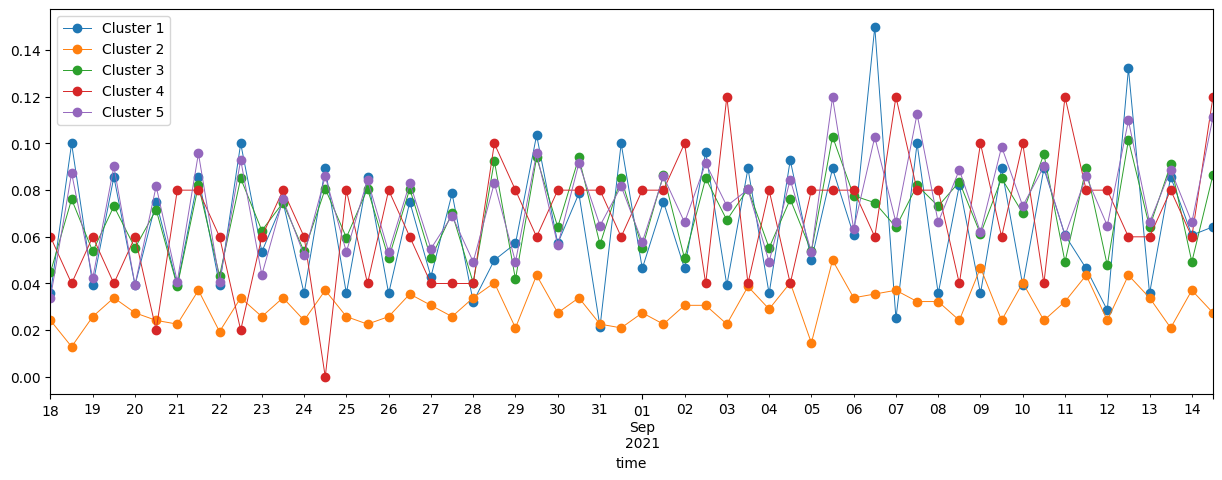

In [115]:
pd.DataFrame(refer_true)[refer_clust_id[refer_clust_id==0].index].mean(axis=1).plot(figsize=(15,5),label='Cluster 1', marker='o', linewidth=0.7)
pd.DataFrame(refer_true)[refer_clust_id[refer_clust_id==1].index].mean(axis=1).plot(label='Cluster 2', marker='o', linewidth=0.7)
pd.DataFrame(refer_true)[refer_clust_id[refer_clust_id==2].index].mean(axis=1).plot(label='Cluster 3', marker='o', linewidth=0.7)
pd.DataFrame(refer_true)[refer_clust_id[refer_clust_id==3].index].mean(axis=1).plot(label='Cluster 4', marker='o', linewidth=0.7)
pd.DataFrame(refer_true)[refer_clust_id[refer_clust_id==4].index].mean(axis=1).plot(label='Cluster 5', marker='o', linewidth=0.7)
# pd.DataFrame(target_true)[target_clust_id[target_clust_id==0].index].mean(axis=1).plot(label='target')
plt.legend()
plt.show()

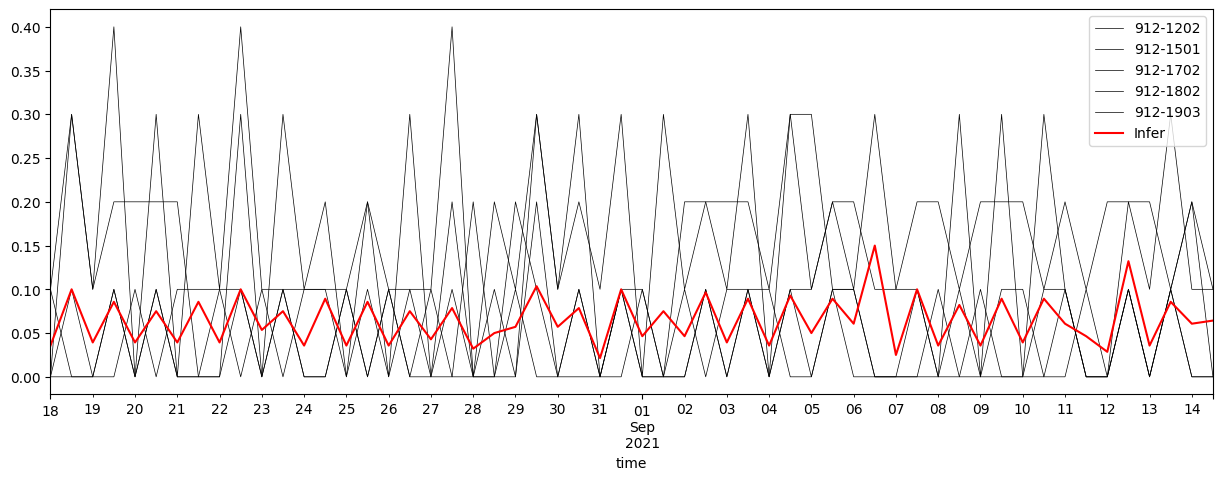

In [56]:
pd.DataFrame(refer_true)[refer_clust_id[refer_clust_id==0].index].iloc[:,:5].plot(figsize=(15,5), color='black', linewidth=0.5)
pd.DataFrame(refer_true)[refer_clust_id[refer_clust_id==0].index].mean(axis=1).plot(figsize=(15,5),label='Infer', color='red')
plt.legend()
plt.show()


In [7]:
# GAE
total_cluster = []
total_test = []
for cluster_method in cluster_methods:
    mae_cluster = []
    mae_test = []
    for i in range(3):
        cluster, si = hw_cluster.cluster_by_GAE(cluster_method,i)
        mae = hw_cluster.predict_target(cluster, si)
        mae_cluster.append(mae)
        cluster, si = hw_test.cluster_by_GAE(cluster_method,i)
        mae = hw_test.predict_target(cluster, si)
        mae_test.append(mae)
    
    print(f'[{cluster_method}]')
    print('cluster MAE mean:',(c_mean:=np.array(mae_cluster).mean()).round(10))
    print('cluster MAE std:',(c_std:=np.array(mae_cluster).std()).round(10))
    print('test MAE mean:',(t_mean:=np.array(mae_test).mean()).round(10))
    print('test MAE std:',(t_std:=np.array(mae_test).std()).round(10))
    print()
    
    total_cluster.append(c_mean)
    total_test.append(t_mean)

df_cluster.loc['GAE'] = total_cluster
df_test.loc['GAE'] = total_test

[kmedoids]
cluster MAE mean: 0.0602544739
cluster MAE std: 0.0008355388
test MAE mean: 0.0566929684
test MAE std: 0.0005916534

[kmeans]
cluster MAE mean: 0.0589002882
cluster MAE std: 0.0003352521
test MAE mean: 0.0556091433
test MAE std: 0.0001109163

[agglomerative]
cluster MAE mean: 0.059998096
cluster MAE std: 0.0004829864
test MAE mean: 0.0566236769
test MAE std: 0.0005543639

[gmm]
cluster MAE mean: 0.059221641
cluster MAE std: 0.0005708986
test MAE mean: 0.0559962545
test MAE std: 0.0001329311



In [7]:
# TAE
total_cluster = []
total_test = []
for cluster_method in cluster_methods:
    mae_cluster = []
    mae_test = []
    for i in range(101, 105):
        cluster, si = hw_cluster.cluster_by_TAE(cluster_method,i)
        mae = hw_cluster.predict_target(cluster, si)
        mae_cluster.append(mae)
        cluster, si = hw_test.cluster_by_TAE(cluster_method,i)
        mae = hw_test.predict_target(cluster, si)
        mae_test.append(mae)
    
    print(f'[{cluster_method}]')
    print('cluster MAE mean:',(c_mean:=np.array(mae_cluster).mean()).round(10))
    print('cluster MAE std:',(c_std:=np.array(mae_cluster).std()).round(10))
    print('test MAE mean:',(t_mean:=np.array(mae_test).mean()).round(10))
    print('test MAE std:',(t_std:=np.array(mae_test).std()).round(10))
    print()
    
    total_cluster.append(c_mean)
    total_test.append(t_mean)

df_cluster.loc['TAE'] = total_cluster
df_test.loc['TAE'] = total_test

[kmedoids]
cluster MAE mean: 0.0726051993
cluster MAE std: 0.00053212
test MAE mean: 0.0715344386
test MAE std: 0.0006881042

[kmeans]
cluster MAE mean: 0.0724460599
cluster MAE std: 0.0005654382
test MAE mean: 0.0716932705
test MAE std: 0.0001433142

[agglomerative]
cluster MAE mean: 0.0734619997
cluster MAE std: 0.000350406
test MAE mean: 0.0727329561
test MAE std: 0.000339988

[gmm]
cluster MAE mean: 0.0732923978
cluster MAE std: 0.0004336754
test MAE mean: 0.0726486741
test MAE std: 0.0001692393



In [8]:
df_cluster

,kmedoids,kmeans,agglomerative,gmm
GAE,0.060254,0.0589,0.059998,0.059222


In [9]:
df_test

,kmedoids,kmeans,agglomerative,gmm
GAE,0.056693,0.055609,0.056624,0.055996


In [8]:
df_cluster.to_csv('/root/workspace/AMI/InferProj/exp_result/hotwater_cluster.csv')
df_test.to_csv('/root/workspace/AMI/InferProj/exp_result/hotwater_test.csv')